In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

# A comment

from __future__ import (print_function, division, absolute_import)

import os
import glob
import copy
import sys
import warnings

import numpy as np

# Matplotlib related
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cmaps
plt.rc('text', usetex=False)

from astropy.table import \
    Table, \
    Column, \
    vstack, \
    hstack, \
    unique
    
from astropy.utils.metadata import MergeConflictWarning
warnings.filterwarnings('ignore', category=MergeConflictWarning, 
                        append=True)
from astropy import units as u
from astropy.coordinates import SkyCoord as sc
from astropy.utils.console import ProgressBar
from astropy import visualization as vs

plt.rcParams['figure.figsize'] = (12, 7)

In [2]:
table_hsc = Table.read('hsc_s16a_fastlane_g09_short.fits', 
                       format = 'fits')
table_decals = Table.read ('decals_dr3_g09_short.fits', 
                           format = 'fits')

table_hsc.sort('rcmodel_mag')
table_decals.sort('rmag_decal')

ra_hsc = table_hsc['ra']
dec_hsc = table_hsc['dec']
ra_decals = table_decals['RA']
dec_decals = table_decals['DEC']

hsc = sc(ra=ra_hsc*u.degree, dec=dec_hsc*u.degree)  
decals = sc(ra=ra_decals*u.degree, dec=dec_decals*u.degree)  
idx, d2d, d3d = hsc.match_to_catalog_sky(decals)

In [3]:
print(len(table_hsc))

2462


### You need to check the "d2d" values which are the separation between matched nearest neighbhors.  

* We only want the ones with separation smaller than 2 or 3 arcsec. 

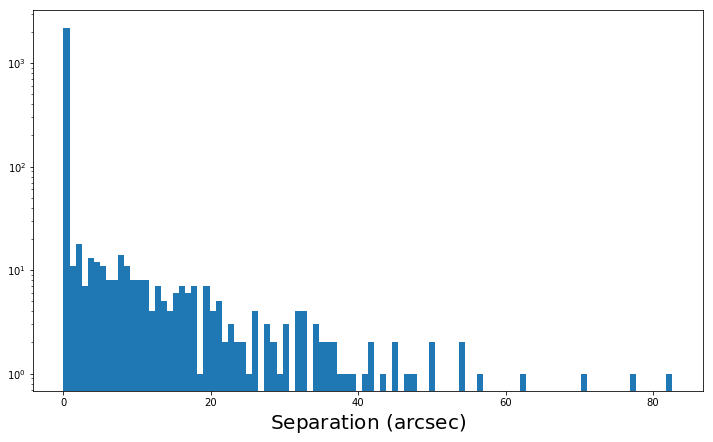

In [4]:
_ = plt.hist(d2d.to(u.arcsec), bins=100, log=True);
plt.xlabel(r'${\rm Separation\ (arcsec)}$', fontsize=20)

In [5]:
idx_use = np.asarray(d2d.to(u.arcsec)) <= 3.0

print(np.sum(idx_use))

2232


### You can merge the catalogs together, then applies a cut on d2d

In [6]:
table_merge = hstack([table_hsc, table_decals[idx]])

table_use = table_merge[idx_use]

### There are better ways to define index arrays 

In [7]:
#split hsc into four redshift bins
hsc_z = table_use['z_best']

#.25-.325, .325-.4, .4-.475, .475-.55
idx_1 = (hsc_z < .325)
idx_2 = ((hsc_z > .325) & (hsc_z < .400))
idx_3 = ((hsc_z > .400) & (hsc_z < .475))
idx_4 = (hsc_z > 0.475)

### Example plots for magnitude differences

In [8]:
r_hsc = table_use['rcmodel_mag'] - table_use['a_r']
r_decal = table_use['rmag_decal'] - table_use['a_r_decal']
r_diff = (r_hsc - r_decal)
mass = table_use['logm_100']

# You can replace xx, yy, cc with the array for X-axis, Y-axis, and color axis
xx = r_hsc
yy = r_diff
cc = mass 
zz = hsc_z

idx_finite = ((np.isfinite(xx)) & 
              (np.isfinite(yy)) & 
              (np.isfinite(cc)) & 
              (np.isfinite(zz)))

xx_use = xx[idx_finite]
yy_use = yy[idx_finite]
cc_use = cc[idx_finite]
zz_use = zz[idx_finite]

idx_1 = (zz_use < .325)
idx_2 = ((zz_use > .325) & (zz_use < .400))
idx_3 = ((zz_use > .400) & (zz_use < .475))
idx_4 = (zz_use > 0.475)

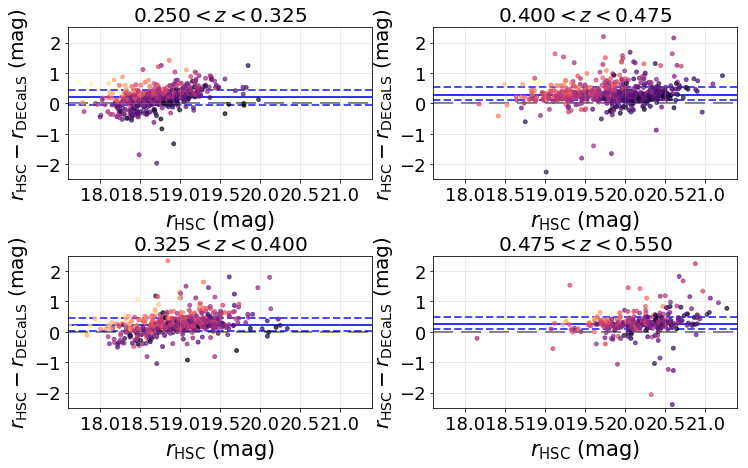

In [9]:
fig, axarr = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.50)

axarr[0,0].scatter(xx_use[idx_1], yy_use[idx_1],
                   c=cc_use[idx_1],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[0,0].set_title(r'$0.250 < z < 0.325$', 
                     fontsize=20)
axarr[0,0].axhline(np.percentile(yy_use[idx_1], 16), 
                   linestyle='--', c='b', linewidth=2.0, 
                   alpha=0.7, zorder=0)
axarr[0,0].axhline(np.percentile(yy_use[idx_1], 84), 
                   linestyle='--', c='b', linewidth=2.0, 
                   alpha=0.7, zorder=0)
axarr[0,0].axhline(np.percentile(yy_use[idx_1], 50), 
                   linestyle='-', c='b', linewidth=2.0, 
                   alpha=0.8, zorder=0)

axarr[1,0].scatter(xx_use[idx_2], yy_use[idx_2],
                   c=cc_use[idx_2],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[1,0].set_title(r'$0.325 < z < 0.400$', 
                     fontsize=20)
axarr[1,0].axhline(np.percentile(yy_use[idx_2], 16), 
                   linestyle='--', c='b', linewidth=2.0, 
                   alpha=0.7, zorder=0)
axarr[1,0].axhline(np.percentile(yy_use[idx_2], 84), 
                   linestyle='--', c='b', linewidth=2.0, 
                   alpha=0.7, zorder=0)
axarr[1,0].axhline(np.percentile(yy_use[idx_2], 50), 
                   linestyle='-', c='b', linewidth=2.0, 
                   alpha=0.8, zorder=0)


axarr[0,1].scatter(xx_use[idx_3], yy_use[idx_3],
                   c=cc_use[idx_3],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[0,1].set_title(r'$0.400 < z < 0.475$', 
                     fontsize=20)
axarr[0,1].axhline(np.percentile(yy_use[idx_3], 16), 
                   linestyle='--', c='b', linewidth=2.0, 
                   alpha=0.7, zorder=0)
axarr[0,1].axhline(np.percentile(yy_use[idx_3], 84), 
                   linestyle='--', c='b', linewidth=2.0, 
                   alpha=0.7, zorder=0)
axarr[0,1].axhline(np.percentile(yy_use[idx_3], 50), 
                   linestyle='-', c='b', linewidth=2.0, 
                   alpha=0.8, zorder=0)

axarr[1,1].scatter(xx_use[idx_4], yy_use[idx_4],
                   c=cc_use[idx_4],
                   label='_nolegend_',
                   cmap=cmaps.magma, 
                   alpha=0.7, s=15)
axarr[1,1].set_title(r'$0.475 < z < 0.550$', 
                     fontsize=20)
axarr[1,1].axhline(np.percentile(yy_use[idx_4], 16), 
                   linestyle='--', c='b', linewidth=2.0, 
                   alpha=0.7, zorder=0)
axarr[1,1].axhline(np.percentile(yy_use[idx_4], 84), 
                   linestyle='--', c='b', linewidth=2.0, 
                   alpha=0.7, zorder=0)
axarr[1,1].axhline(np.percentile(yy_use[idx_4], 50), 
                   linestyle='-', c='b', linewidth=2.0, 
                   alpha=0.8, zorder=0)

for (m,n), subplot in np.ndenumerate(axarr):
    subplot.set_xlim(17.6, 21.4)
    subplot.set_ylim(-2.5, 2.5)
    
    # zorder=0 puts the grid in the background
    subplot.grid(alpha=0.3, zorder=0)
    
    subplot.set_xlabel(r'$r_{\rm HSC}\ ({\rm mag})$', fontsize=21)
    subplot.set_ylabel(r'$r_{\rm HSC}-r_{\rm DECaLS}\ ({\rm mag})$', 
                       fontsize=20)
    
    subplot.axhline(0.0, linewidth=2.0, alpha=0.5, c='k', 
                    zorder=0, linestyle='--', dashes=(10, 4))
    
    for tick in subplot.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    for tick in subplot.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    